# Evaluate DeepFace's Results In The Big Picture

In [1]:
import pandas as pd
from IPython.display import display, HTML
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
alignment = [False, True]
models = ["Facenet512", "Facenet", "VGG-Face", "ArcFace", "Dlib", "GhostFaceNet", "SFace", "OpenFace", "DeepFace", "DeepID", "yolov8", "yolov11n", "yolov11s", "yolov11m"]
detectors = ["retinaface", "mtcnn", "fastmtcnn", "dlib", "yolov8", "yolov11n", "yolov11s", "yolov11m", "yunet", "centerface", "mediapipe", "ssd", "opencv", "skip"]
distance_metrics = ["euclidean", "euclidean_l2", "cosine"]

# Main results

In [3]:
for align in alignment:
    for metric in distance_metrics:
        df = pd.read_csv(f"results/pivot_{metric}_with_alignment_{align}.csv")
        df = df.rename(columns = {'Unnamed: 0': 'detector'})
        df = df.set_index('detector')

        print(f"{metric} for alignment {align}")
        display(HTML(df.to_html()))
        display(HTML("<hr>"))

euclidean for alignment False


,Facenet512,Facenet,VGG-Face,ArcFace,Dlib,GhostFaceNet,SFace,OpenFace,DeepFace,DeepID
detector,,,,,,,,,,
retinaface,96.1,92.8,95.7,84.1,88.3,83.2,78.6,70.8,67.4,64.3
mtcnn,95.9,92.5,95.5,81.8,89.3,83.2,76.3,70.9,65.9,63.2
fastmtcnn,96.3,93.0,96.0,82.2,90.0,82.7,76.8,71.2,66.5,64.3
dlib,96.0,89.0,94.1,82.6,96.3,65.6,73.1,75.9,61.8,61.9
yolov8,94.8,90.8,95.2,83.2,88.4,77.6,71.6,68.9,68.2,66.3
yunet,97.9,96.5,96.3,84.1,91.4,82.7,78.2,71.7,65.5,65.2
centerface,97.4,95.4,95.8,83.2,90.3,82.0,76.5,69.9,65.7,62.9
mediapipe,94.9,87.1,93.1,71.1,91.9,61.9,73.2,77.6,61.7,62.4
ssd,97.2,94.9,96.7,83.9,88.6,84.9,82.0,69.9,66.7,64.0


euclidean_l2 for alignment False


,Facenet512,Facenet,VGG-Face,ArcFace,Dlib,GhostFaceNet,SFace,OpenFace,DeepFace,DeepID
detector,,,,,,,,,,
retinaface,98.0,95.9,95.7,95.7,88.4,89.5,90.6,70.8,67.7,64.6
mtcnn,97.8,96.2,95.5,95.9,89.2,88.0,91.1,70.9,67.0,64.0
fastmtcnn,97.7,96.6,96.0,95.9,89.6,87.8,89.7,71.2,67.8,64.2
dlib,96.5,89.9,94.1,93.8,95.6,63.0,75.0,75.9,62.6,61.8
yolov8,97.7,95.8,95.2,95.0,88.1,88.7,89.8,68.9,68.9,65.3
yunet,98.3,96.8,96.3,96.1,91.7,88.0,90.5,71.7,67.6,63.2
centerface,97.4,96.3,95.8,95.8,90.2,86.8,89.3,69.9,68.4,63.1
mediapipe,96.3,90.0,93.1,89.3,91.8,65.6,74.6,77.6,64.9,61.6
ssd,97.9,97.0,96.7,96.6,89.4,91.5,93.0,69.9,68.7,64.9


cosine for alignment False


,Facenet512,Facenet,VGG-Face,ArcFace,Dlib,GhostFaceNet,SFace,OpenFace,DeepFace,DeepID
detector,,,,,,,,,,
retinaface,98.0,95.9,95.7,95.7,88.4,89.5,90.6,70.8,67.7,63.7
mtcnn,97.8,96.2,95.5,95.9,89.2,88.0,91.1,70.9,67.0,64.0
fastmtcnn,97.7,96.6,96.0,95.9,89.6,87.8,89.7,71.2,67.8,62.7
dlib,96.5,89.9,94.1,93.8,95.6,63.0,75.0,75.9,62.6,61.7
yolov8,97.7,95.8,95.2,95.0,88.1,88.7,89.8,68.9,68.9,65.3
yunet,98.3,96.8,96.3,96.1,91.7,88.0,90.5,71.7,67.6,63.2
centerface,97.4,96.3,95.8,95.8,90.2,86.8,89.3,69.9,68.4,62.6
mediapipe,96.3,90.0,93.1,89.3,91.8,64.8,74.6,77.6,64.9,61.6
ssd,97.9,97.0,96.7,96.6,89.4,91.5,93.0,69.9,68.7,63.8


euclidean for alignment True


,Facenet512,Facenet,VGG-Face,ArcFace,Dlib,GhostFaceNet,SFace,OpenFace,DeepFace,DeepID
detector,,,,,,,,,,
retinaface,95.9,93.5,95.8,85.2,88.9,85.9,80.2,69.4,67.0,65.6
mtcnn,95.2,93.8,95.9,83.7,89.4,83.0,77.4,70.2,66.5,63.3
fastmtcnn,96.0,93.4,95.8,83.5,91.1,82.8,77.7,69.4,66.7,64.0
dlib,96.0,90.8,94.5,88.6,96.8,65.7,66.3,75.8,63.4,60.4
yolov8,94.4,91.9,95.0,84.1,89.2,77.6,73.4,68.7,69.0,66.5
yunet,97.3,96.1,96.0,84.9,92.2,84.0,79.4,70.9,65.8,65.2
centerface,97.6,95.8,95.7,83.6,90.4,82.8,77.4,68.9,65.5,62.8
mediapipe,95.1,88.6,92.9,73.2,93.1,63.2,72.5,78.7,61.8,62.2
ssd,88.9,85.6,87.0,75.8,83.1,79.1,76.9,66.8,63.4,62.5


euclidean_l2 for alignment True


,Facenet512,Facenet,VGG-Face,ArcFace,Dlib,GhostFaceNet,SFace,OpenFace,DeepFace,DeepID
detector,,,,,,,,,,
retinaface,98.4,96.4,95.8,96.6,89.1,90.5,92.4,69.4,67.7,64.4
mtcnn,97.6,96.8,95.9,96.0,90.0,89.8,90.5,70.2,66.4,64.0
fastmtcnn,98.1,97.2,95.8,96.4,91.0,89.5,90.0,69.4,67.4,64.1
dlib,97.0,92.6,94.5,95.1,96.4,63.3,69.8,75.8,66.5,59.5
yolov8,97.3,95.7,95.0,95.5,88.8,88.9,91.9,68.7,67.5,66.0
yunet,97.9,97.4,96.0,96.7,91.6,89.1,91.0,70.9,66.5,63.6
centerface,97.7,96.8,95.7,96.5,90.9,87.5,89.3,68.9,67.8,64.0
mediapipe,96.1,90.6,92.9,90.3,92.6,64.4,75.4,78.7,64.7,63.0
ssd,88.7,87.5,87.0,86.2,83.3,82.2,84.6,66.8,64.1,62.6


cosine for alignment True


,Facenet512,Facenet,VGG-Face,ArcFace,Dlib,GhostFaceNet,SFace,OpenFace,DeepFace,DeepID
detector,,,,,,,,,,
retinaface,98.4,96.4,95.8,96.6,89.1,90.5,92.4,69.4,67.7,64.4
mtcnn,97.6,96.8,95.9,96.0,90.0,89.8,90.5,70.2,66.3,63.0
fastmtcnn,98.1,97.2,95.8,96.4,91.0,89.5,90.0,69.4,67.4,63.6
dlib,97.0,92.6,94.5,95.1,96.4,63.3,69.8,75.8,66.5,58.7
yolov8,97.3,95.7,95.0,95.5,88.8,88.9,91.9,68.7,67.5,65.9
yunet,97.9,97.4,96.0,96.7,91.6,89.1,91.0,70.9,66.5,63.5
centerface,97.7,96.8,95.7,96.5,90.9,87.5,89.3,68.9,67.8,63.6
mediapipe,96.1,90.6,92.9,90.3,92.6,64.3,75.4,78.7,64.8,63.0
ssd,88.7,87.5,87.0,86.2,83.3,82.2,84.5,66.8,63.8,62.6


In [4]:
def create_github_table():
    for metric in distance_metrics:
        for align in [True, False]:
            df = pd.read_csv(f"results/pivot_{metric}_with_alignment_{align}.csv")
            df = df.rename(columns = {'Unnamed: 0': 'detector'})
            df = df.set_index('detector')
            
            print(f"Performance Matrix for {metric} while alignment is {align} \n")
            header = "| | "
            for col_name in df.columns.tolist():
                header += f"{col_name} |"
            print(header)
            # -------------------------------
            seperator = "| --- | "
            for col_name in df.columns.tolist():
                seperator += " --- |"
            print(seperator)
            # -------------------------------
            for index, instance in df.iterrows():
                line = f"| {instance.name} |"
                for i in instance.values:
                    if i < 97.5:
                        line += f"{i} |"
                    else:
                        line += f"**{i}** |"
                print(line)
            
            print("\n---------------------------")

In [6]:
# create_github_table()

# Alignment impact

In [7]:
align_df = None

for distance_metric in distance_metrics:
    df1 = (
        pd.read_csv(f"results/pivot_{distance_metric}_with_alignment_True.csv")
        .rename(columns = {'Unnamed: 0': 'detector'})
        .set_index('detector')
    )
    df2 = (
        pd.read_csv(f"results/pivot_{distance_metric}_with_alignment_False.csv")
        .rename(columns = {'Unnamed: 0': 'detector'})
        .set_index('detector')
    )
    df1 = df1[df1.index != "skip"]
    df2 = df2[df2.index != "skip"]
    pivot_df = df1.subtract(df2)
    
    pivot_df = pivot_df.max()
    pivot_df = pd.DataFrame(pivot_df, columns=[f'alignment_impact_of_{distance_metric}'])
    # display(HTML(pivot_df.to_html()))

    if align_df is None:
        align_df = pivot_df.copy()
    else:
        align_df = align_df.merge(pivot_df, left_index=True, right_index=True)

# display(HTML(align_df.to_html()))
align_df = pd.DataFrame(align_df.max(axis=1), columns = ["max_alignment_impact"])
align_df = align_df.sort_values(by=["max_alignment_impact"], ascending=False)
display(HTML(align_df.to_html()))

,max_alignment_impact
ArcFace,6.0
DeepFace,3.9
GhostFaceNet,2.7
Facenet,2.7
SFace,2.1
Dlib,1.4
DeepID,1.4
OpenFace,1.1
Facenet512,0.5
VGG-Face,0.4


## Detection impact

In [8]:
detect_df = None
for distance_metric in distance_metrics:
    tmp_df = (
        pd.read_csv(f"results/pivot_{distance_metric}_with_alignment_False.csv")
        .rename(columns = {'Unnamed: 0': 'detector'})
        .set_index('detector')
    )
    ref_df = tmp_df[tmp_df.index == "skip"]
    
    j = []
    for i in range(0, len(detectors) - 1):
        j.append(ref_df)
    minus_df = pd.concat(j)
    
    tmp_df = tmp_df[tmp_df.index != "skip"]
    minus_df.index = tmp_df.index
    
    # print("performance with no detection")
    # display(HTML(ref_df.to_html()))
    
    # print("pivot")
    tmp_df = tmp_df.subtract(minus_df)
    # display(HTML(tmp_df.to_html()))
    
    # print("avg of detector impact for models")
    # avg_df = pd.DataFrame(tmp_df.mean()).T
    avg_df = pd.DataFrame(tmp_df.max(), columns=[f"detection_impact_of_{distance_metric}"])
    # display(HTML(avg_df.to_html()))

    if detect_df is None:
        detect_df = avg_df.copy()
    else:
        detect_df = detect_df.merge(avg_df, left_index=True, right_index=True)

# display(HTML(detect_df.to_html()))
detect_df = pd.DataFrame(detect_df.max(axis=1), columns = ["max_detection_impact"])
detect_df = detect_df.sort_values(by=["max_detection_impact"], ascending=False)
display(HTML(detect_df.to_html()))


,max_detection_impact
ArcFace,41.8
Facenet,32.4
Dlib,27.3
OpenFace,20.2
GhostFaceNet,15.9
SFace,9.6
DeepFace,7.6
Facenet512,6.9
VGG-Face,6.1
DeepID,5.6


# facial recognition model's best scores

In [9]:
df = pd.DataFrame()
for align in alignment:
    for distance_metric in distance_metrics:
        tmp_df = (
            pd.read_csv(f"results/pivot_{distance_metric}_with_alignment_{align}.csv")
            .rename(columns = {'Unnamed: 0': 'detector'})
            .set_index('detector')
        )
        df = pd.concat([df, tmp_df])

pivot_df = pd.DataFrame(df.max(), columns = ["best_accuracy_score"])

# add human comparison
pivot_df.loc["Human-beings"] = 97.5

pivot_df = pivot_df.sort_values(by = ["best_accuracy_score"], ascending = False)
pivot_df

,best_accuracy_score
Facenet512,98.4
Human-beings,97.5
Facenet,97.4
Dlib,96.8
VGG-Face,96.7
ArcFace,96.7
GhostFaceNet,93.3
SFace,93.0
OpenFace,78.7
DeepFace,69.0


# ROC Curves

In [10]:
def plot_roc(model_name, detector_backend, distance_metric, align):
    alignment_text = "aligned" if align == True else "unaligned"

    df = pd.read_csv(f"outputs/test/{model_name}_{detector_backend}_{distance_metric}_{alignment_text}.csv")
    
    #normalize
    df["distances_normalized"] = df["distances"] / df["distances"].max()
    df["actuals_normalized"] = 0
    idx = df[df["actuals"] == False].index
    df.loc[idx, "actuals_normalized"] = 1
    
    y_actual = df["actuals_normalized"].values.tolist()
    y_pred_proba = df["distances_normalized"].values.tolist()
    
    fpr, tpr, _ = metrics.roc_curve(y_actual, y_pred_proba)
    auc = metrics.roc_auc_score(y_actual, y_pred_proba)
    auc = round(auc, 4)

    # best accuracy score
    result_path = f"results/pivot_{distance_metric}_with_alignment_{align}.csv"
    result_df = pd.read_csv(result_path)
    acc = result_df[result_df["Unnamed: 0"] == detector_backend][model_name].values[0]

    label = f"{model_name}_{detector_backend}_{distance_metric}_{alignment_text} (acc: {acc}, auc: {auc})"

    return acc, auc, fpr, tpr, label

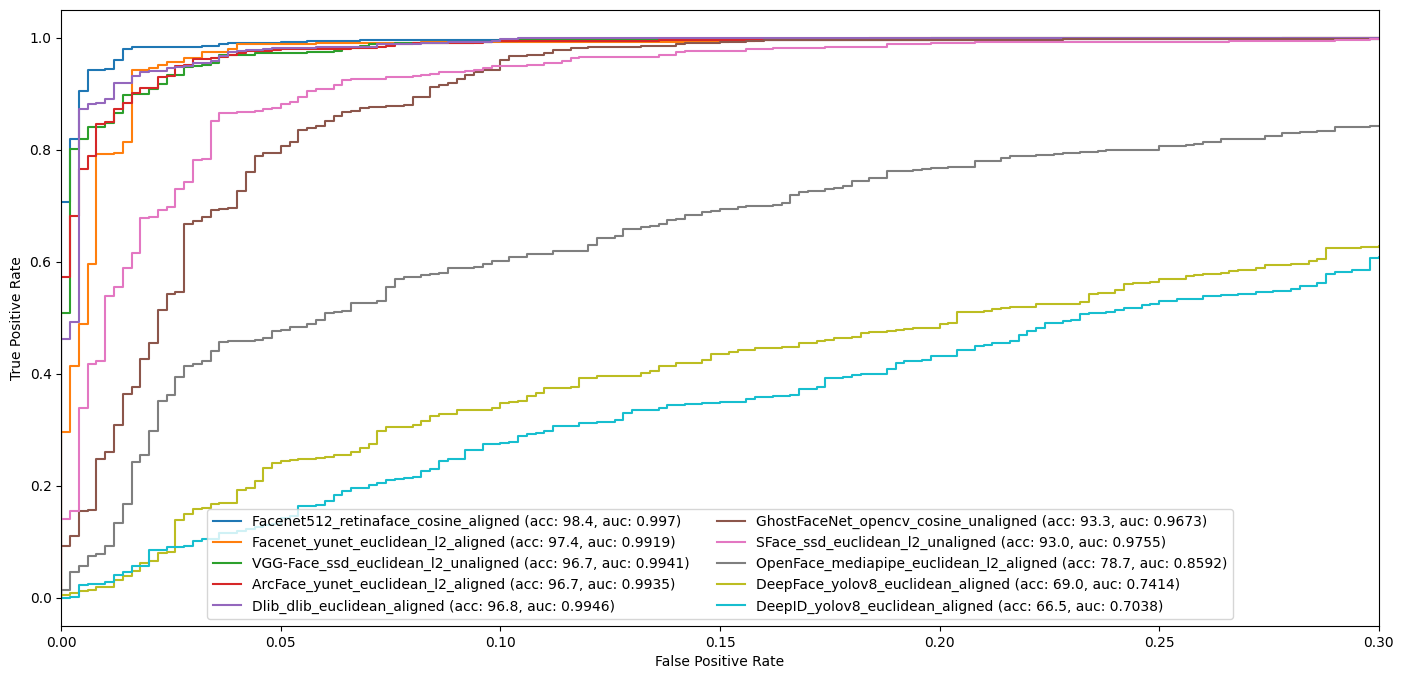

In [11]:
# to show all models in same graph
plt.figure(figsize=(17, 8))

for model_name in models:
    # to show graphs model by model
    # plt.figure(figsize=(17, 8))
    accs = []
    aucs = []
    fprs = []
    tprs = []
    labels = []
    for distance_metric in distance_metrics:
        # for detector_backend in robust_face_detectors:
        for detector_backend in detectors:
            for align in alignment:
                if detector_backend == "skip" and align is True:
                    continue
                acc, auc, fpr, tpr, label = plot_roc(model_name, detector_backend, distance_metric, align)
                accs.append(acc)
                aucs.append(auc)
                fprs.append(fpr)
                tprs.append(tpr)
                labels.append(label)
    # ---------------------------------
    #sort by auc
    df = pd.DataFrame({"acc": accs, "auc": aucs, "fpr": fprs, "tpr": tprs, "label": labels})
    # df = df.sort_values(by = ["auc"], ascending = False).reset_index()
    df = df.sort_values(by = ["acc"], ascending = False).reset_index()
    
    for index, instance in df.iterrows():
        fpr = instance["fpr"]
        tpr = instance["tpr"]
        auc = instance["auc"]
        acc = instance["acc"]
        label = instance["label"]
        
        plt.plot(fpr, tpr, label=label)
        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")
        plt.legend(loc="lower center", ncol=2)
        # normally this should be [0, 1] but that scale makes graphs not legible
        # plt.xlim([0, 1])
        plt.xlim([0, 0.3])

        # to show the best auc value
        break
    
    # to show graphs model by model
    # plt.show()
    # print("----------------")

# to show all models in same graph
plt.show()